# La più semplice rete neurale per trovare la retta che meglio modella un insieme di punti (x,y)
Luca Mari, marzo 2024  

[i file di questa attività: [linear.ipynb](linear.ipynb), [linearutils.py](linearutils.py)]

**Obiettivi**: comprendere il funzionamento di base di una semplice rete neurale, per come specificato in Python mediante un modulo di alto livello come `PyTorch`.  
**Precompetenze**: basi di Python.

Per eseguire questo notebook, supponiamo con VSCode, occorre:
* installare un interprete Python
* scaricare da https://code.visualstudio.com/download e installare VSCode
* eseguire VSCode e attivare le estensioni per Python e Jupyter
* ancora in VSCode:
    * creare una cartella di lavoro e renderla la cartella corrente
    * copiare nella cartella questo notebook e il file `linearutils.py` e aprire il notebook
    * creare un ambiente virtuale locale Python (Select Kernel | Python Environments | Create Python Environment | Venv, e scegliere un interprete Python):
    * installare i moduli Python richiesti, eseguendo dal terminale:  
        `pip install torch matplotlib ipympl`

Supponiamo di disporre di un insieme di dati $(x_i, y_i)$, e da questo di voler costruire una funzione $f$ in grado di prevedere un $y$ per ogni $x$ dato, dunque tale che $y = f(x)$. Per ogni $x_i$, indicheremo dunque con $y_i$ il dato nel training set e con $\hat y_i$ il valore previsto dal modello.

Ipotizziamo che il modello $f$ da costruire sia una funzione lineare, dunque geometricamente una retta $y = k_0 + k_1 x$, così che il modello è una funzione a due parametri, $y = f_{k_0, k_1}(x)$, di cui occorre stimare i valori: si tratta di un problema noto in statistica come *regressione lineare*.

Il problema è così semplice che potrebbe essere risolto per via analitica, con il metodo dei minimi quadrati. Noi lo risolveremo però per via numerica, costruendo una semplice rete neurale, da addestrare mediante il *training set* $\{(x_i, y_i)\}$.

Importiamo prima di tutto i moduli Python necessari.

In [1]:
%matplotlib widget
from linearutils import get_params, plot, train
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

Costruiamo il *training set*, che supponiamo generato dalla sovrapposizione di valori disposti su una retta e di valori casuali estratti da una distribuzione normale standard, dunque a media 0 e deviazione standard 1, e quindi rappresentiamolo graficamente.

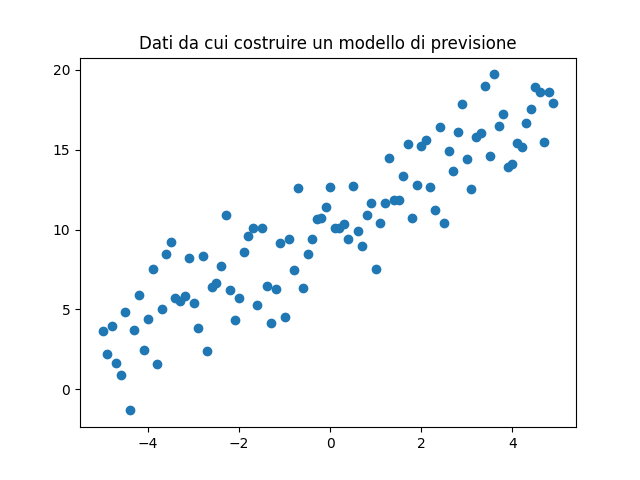

In [2]:
z0, z1 = 10, 1.5                # i valori veri, e supposti ignoti e da stimare, dei parametri della retta e dunque del modello

x = torch.arange(-5, 5, 0.1).view(-1, 1)
y = z0 + z1 * x + 2 * torch.randn(x.size())

plot(x, y, 'Dati da cui costruire un modello di previsione')

Costruiamo una rete neurale con un neurone di input e uno di output, per *x* e *y* rispettivamente, che avrà dunque due parametri, $k_0$ e $k_1$, corrispondenti all'intercetta della retta (il bias) e alla pendenza della retta (il "peso" della connessione). I valori iniziali di $k_0$ e $k_1$ sono casuali, e quindi la retta di regressione non ha alcuna affidabilità. 

[0.35, 0.2]


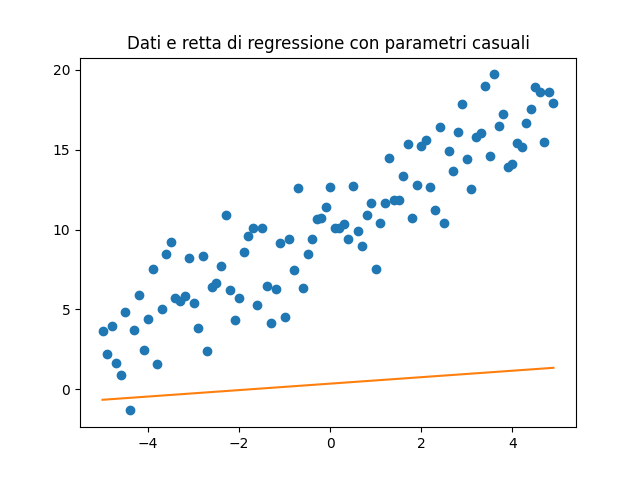

In [3]:
model = torch.nn.Linear(1, 1)

print(get_params(model, 2))
plot(x, y, 'Dati e retta di regressione con parametri casuali', model)

Scegliamo come addestrare la rete specificando:
* l'iperparametro tasso di apprendimento (*learning rate*, lr);
* l'iperparametro numero di epoche;
* il criterio per valutare la qualità delle previsioni, in questo caso l'errore quadratico medio (*mean squared error*, MSE);
* il metodo di ottimizzazione, in questo caso la *back propagation* mediante discesa stocastica lungo il gradiente (*stochastic gradient descent*, SGD).

In [4]:
lr = 0.1
num_epochs = 20
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

Addestriamo la rete, visualizzando per ogni epoca le stime dei parametri e il valore della funzione di errore, e alla fine il grafico con la retta di regressione risultante.  
Per ora operiamo "a scatola chiusa", dunque senza interessarci di come l'addestramento si realizza.

epoca	parametri	MSE
1	[2.32, 2.31]	115.33
2	[3.91, 0.92]	72.74
3	[5.17, 1.87]	46.91
4	[6.19, 1.25]	31.01
5	[7.0, 1.67]	21.11
6	[7.65, 1.4]	14.9
7	[8.17, 1.59]	10.98
8	[8.58, 1.47]	8.5
9	[8.92, 1.55]	6.92
10	[9.18, 1.5]	5.91
11	[9.39, 1.54]	5.27
12	[9.56, 1.51]	4.86
13	[9.7, 1.53]	4.6
14	[9.81, 1.52]	4.43
15	[9.9, 1.53]	4.33
16	[9.97, 1.52]	4.26
17	[10.02, 1.53]	4.22
18	[10.07, 1.52]	4.19
19	[10.1, 1.53]	4.17
20	[10.13, 1.53]	4.16


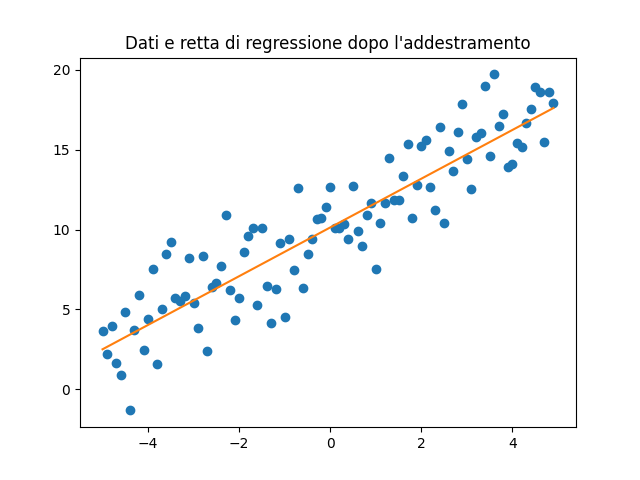

In [5]:
train(model, criterion, optimizer, x, y, num_epochs)
plot(x, y, "Dati e retta di regressione dopo l'addestramento", model)

Possiamo ora "aprire la scatola" per vedere come l'addestramento si realizza, e visualizzando la retta di regressione alla fine di ogni epoca, per mostrare la convergenza progressiva verso la retta che meglio stima quella da cui i dati nel *training set* sono stati generati.  
Il codice qui sotto, che tra l'altro contiene vari dettagli concettualmente non così rilevanti, è basato su `PyTorch`.

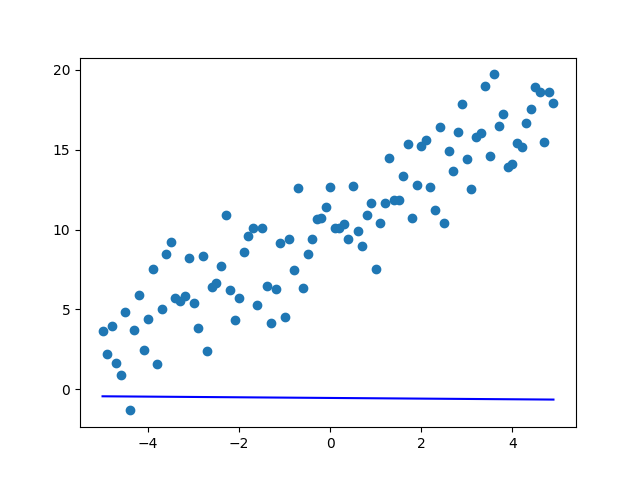

In [6]:
model = torch.nn.Linear(1, 1)
lr = 0.05
num_epochs = 50
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = lr)

xx, yy = x.numpy(), y.numpy()
plt.close('all')
fig, ax = plt.subplots()
ax.scatter(xx, yy, marker='o')
[k0, k1] = get_params(model)
line, = ax.plot(xx, k0 + k1 * xx, color='blue')

def update(epoch):
    y1 = model(x)                           # inferenza: calcola i valori y previsti dal modello
    loss = criterion(y1, y)                 # calcola il valore della funzione di errore
    optimizer.zero_grad()
    loss.backward()                         # backpropagation: calcola il gradiente della funzione di errore
    optimizer.step()                        # aggiorna i parametri del modello
    mse = torch.mean((y1 - y)**2)           # calcola il nuovo valore della funzione di errore
    line.set_ydata(y1.detach().numpy())
    plt.title(f'epoca = {epoch+1},   MSE={mse:.2f}')
    return line,

_ = FuncAnimation(fig, update, frames=num_epochs, interval=100, repeat=False)
plt.show()


Come ultimo passo, possiamo "aprire la scatola" ancora di più, evitare di usare `PyTorch` e scrivendo tutto "a mano".

Ricordiamo che la funzione di errore che abbiamo scelto, lo scarto quadratico medio (*mean square error*, MSE) tra training set e retta / modello, è definita così:  
> $\sum\limits_{i=1}^n (\hat y_i - y_i)^2 / n = \sum\limits_{i=1}^n (k_0 + k_1 x_i - y_i)^2 / n$

in cui $\hat y_i$ è dunque un valore previsto dal modello.

Per risolvere il problema, consideriamo l'MSE come una funzione dei parametri $k_0$ e $k_1$:  
> $g(k_0, k_1) = \sum\limits_{i=1}^n (k_0 + k_1 x_i - y_i)^2 / n$.

Trovando i valori di $k_0$ e $k_1$ che rendono minimo il valore di $g$, avremo risolto il problema.  
Per via analitica, questo corrisponderebbe a calcolare il gradiente $\nabla g(k_0, k_1)$ di $g(k_0, k_1)$ e quindi trovare i valori dei suoi argomenti per cui $\nabla g(k_0, k_1) = 0$ (per come è definita, è chiaro che la funzione $g$ non ha un massimo, e dunque un suo zero sarebbe appunto un minimo). A questa idea è ispirato l'algoritmo della "discesa lungo il gradiente" della funzione $g$.

Dato il fatto che le componenti di $\nabla g$, cioè le derivate parziali della funzione $g(k_0, k_1)$, sono  
> $\partial g(k_0, k_1) / \partial k_0 = 2 \sum_{i=1}^n (k_0 + k_1 x_i - y_i) / n$  
> $\partial g(k_0, k_1) / \partial k_1 = 2 \sum_{i=1}^n (x_i (k_0 + k_1 x_i - y_i) / n)$  

e dopo aver assegnato un valore iniziale a $k_0$ e $k_1$ (*passo 0*):
* per ogni $x_i$ nel training set, si calcola $\hat y_i = k_0 + k_1 x_i$ (*passo 1*);
* si calcolano le derivate parziali $\partial g / \partial k_0$ e $\partial g / \partial k_1$ (*passo 2*);
* si modificano i valori di $k_0$ e $k_1$ "verso lo zero" del gradiente (*passo 3*), dunque  
    $k_0 = k_0 - z \partial g / \partial k_0$  
    $k_1 = k_1 - z \partial g / \partial k_1$  
  dove $z$ determina la rapidità dell'apprendimento (*learning rate*),

ripetendo il processo per il numero di volte specificato.

L'animazione mostra come, ripetendo il passo dell'addestramento, il valore dell'MSE si riduce, e i valori dei parametri si avvicinano progressivamente ai valori dei parametri che erano stati usati per generare il training set.

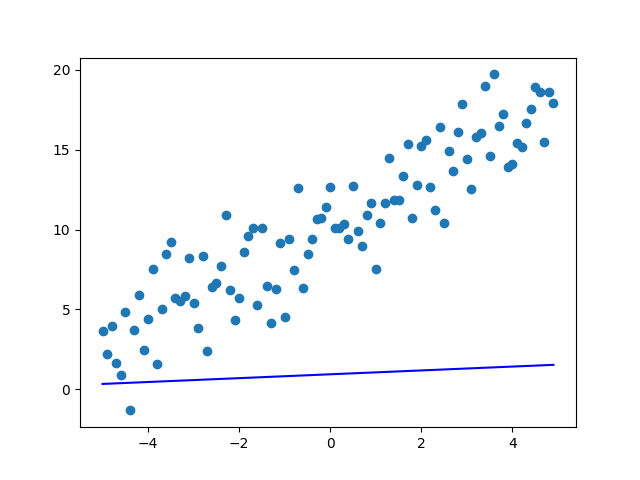

In [7]:
from random import random
import numpy as np

xx, yy = x.numpy(), y.numpy()
plt.close('all')
fig2, ax2 = plt.subplots()
ax2.scatter(xx, yy, marker='o')
k0, k1 = random(), random()                 # passo 0: inizializzazione casuale dei parametri del modello
line2, = ax2.plot(xx, k0 + k1 * xx, color='blue')

lr = 0.05
num_epochs = 50

def update2(epoch):
    global k0, k1
    y1 = k0 + k1 * xx                       # passo 1: inferenza: calcola i valori y previsti dal modello
    d0 = np.mean(2 * (y1 - yy))             # passo 2: backpropagation: calcola il gradiente della funzione di errore
    d1 = np.mean(2 * xx * (y1 - yy))
    k0 = k0 - lr * d0                       # passo 3: aggiorna i parametri del modello
    k1 = k1 - lr * d1
    mse = np.mean((y1 - yy)**2)             # calcola il nuovo valore della funzione di errore
    line2.set_ydata(y1)
    plt.title(f'epoca = {epoch+1}, k0 = {k0:.2f}, k1 = {k1:.2f} (MSE={mse:.2f})')
    return line2,

_ = FuncAnimation(fig2, update2, frames=num_epochs, interval=100, repeat=False)
plt.show()